In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re

In [2]:
df = pd.read_csv('IMDB Dataset.csv')

In [3]:
df.shape

(50000, 2)

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## Data Cleaning

In [6]:
# Mengubah nilai positive menjadi 1 dan negative menjadi 0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})


In [7]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def text_cleaning(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    lemmatized_words = [lemmatizer.lemmatize(word, pos="v") for word in filtered_sentence]
    text = " ".join(lemmatized_words)

    return text

In [9]:
df.review = df['review'].apply(text_cleaning)

In [10]:
df.head()

,review,sentiment
0,One reviewers mention watch Oz episode youll h...,1
1,wonderful little production film technique una...,1
2,think wonderful way spend time hot summer week...,1
3,Basically theres family little boy Jake think ...,0
4,Petter Matteis Love Time Money visually stun f...,1


In [11]:
def sum_word(sentence):
  words= sentence.split()
  word_count = len(words)
  return word_count

Saya membuat kolom count_word untuk menentukan panjang maksimum setiap review

In [12]:
df['count_word']= df['review'].apply(sum_word)

In [13]:
df.describe()

,sentiment,count_word
count,50000.000000,50000.000000
mean,0.500000,118.579840
std,0.500005,89.247297
min,0.000000,3.000000
25%,0.000000,64.000000
50%,0.500000,88.000000
75%,1.000000,144.000000
max,1.000000,1420.000000


In [14]:
unique_words = set(" ".join(df['review']).split())
print("Jumlah kata unik dalam dataset:", len(unique_words))

Jumlah kata unik dalam dataset: 236145


## Feature Selection

In [15]:
from sklearn.model_selection import train_test_split
X = df['review'].values
y = df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Tokenization

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 25000  # Jumlah kata unik yang akan diambil
max_len = 100      # Panjang maksimum setiap review, saya mengambil 100 karena median count word adalah 98 saya bulatkan menjadi 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')


## Modeling

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, GlobalMaxPool1D

model = Sequential([
    Embedding(input_dim=max_words, output_dim=16, input_length=max_len),
    Bidirectional(LSTM(16,dropout=0.5, return_sequences = True)),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           400000    
                                                                 
 bidirectional (Bidirection  (None, 100, 32)           4224      
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [19]:
from tensorflow.keras.callbacks import Callback, EarlyStopping
class MyCallback(Callback):
   def on_epoch_end(self, epoch, logs={}):
      if (logs.get('accuracy') >= 0.90) and (logs.get('val_accuracy') >= 0.90):
          print("\nReached 90% accuracy, stopping training")
          self.model.stop_training = True

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [20]:
history= model.fit(train_padded, y_train,
          epochs=20,
          batch_size=100,
          validation_data=(test_padded, y_test),
          verbose=2,
          callbacks=[MyCallback(), early_stopping]
          )

Epoch 1/20
400/400 - 55s - loss: 0.6688 - accuracy: 0.6746 - val_loss: 0.3727 - val_accuracy: 0.8541 - 55s/epoch - 137ms/step
Epoch 2/20
400/400 - 20s - loss: 0.3480 - accuracy: 0.8699 - val_loss: 0.3268 - val_accuracy: 0.8725 - 20s/epoch - 49ms/step
Epoch 3/20
400/400 - 11s - loss: 0.2784 - accuracy: 0.9020 - val_loss: 0.3241 - val_accuracy: 0.8790 - 11s/epoch - 28ms/step
Epoch 4/20
400/400 - 8s - loss: 0.2321 - accuracy: 0.9202 - val_loss: 0.3299 - val_accuracy: 0.8774 - 8s/epoch - 21ms/step
Epoch 5/20
400/400 - 7s - loss: 0.1976 - accuracy: 0.9343 - val_loss: 0.3619 - val_accuracy: 0.8737 - 7s/epoch - 16ms/step
Epoch 6/20
400/400 - 7s - loss: 0.1767 - accuracy: 0.9429 - val_loss: 0.3502 - val_accuracy: 0.8673 - 7s/epoch - 18ms/step
Epoch 7/20
400/400 - 7s - loss: 0.1622 - accuracy: 0.9487 - val_loss: 0.3850 - val_accuracy: 0.8659 - 7s/epoch - 18ms/step
Epoch 8/20
400/400 - 6s - loss: 0.1446 - accuracy: 0.9547 - val_loss: 0.3783 - val_accuracy: 0.8684 - 6s/epoch - 14ms/step


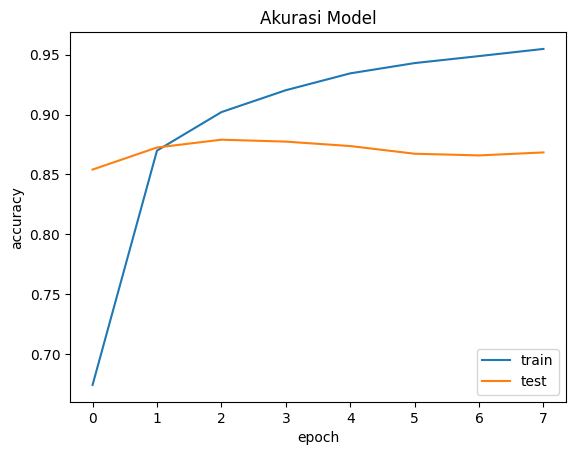

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

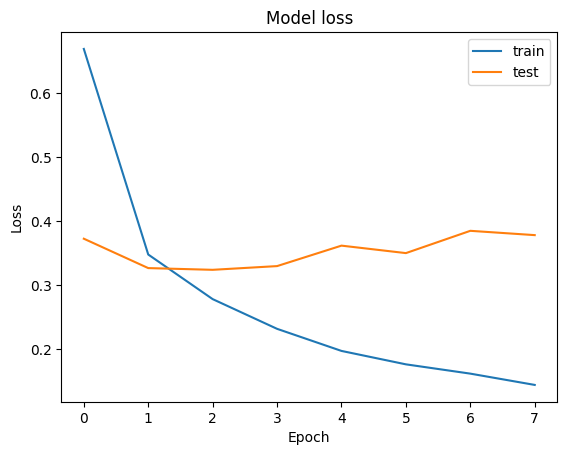

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper right')
plt.show()

### Testing

In [25]:
reviews = ["this movie is really cool!", "i dont like this movie because it's boring"]
sequences = tokenizer.texts_to_sequences(reviews)
reviews_padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

pred = model.predict(reviews_padded)
for review, prediction in zip(reviews, pred):
    sentiment = 'positive' if prediction >= 0.5 else 'negative'
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")

1/1 [==============================] - 0s 34ms/step
Review: this movie is really cool!
Predicted Sentiment: positive

Review: i dont like this movie because it's boring
Predicted Sentiment: negative

